# Market price of a Fiat Punto Evo car

After collecting the data from the website autoscout24.it for a car Fiat Punto Evo model, we analyse the data and set a machine learning (ML) model to predict the price of the customer's car.

## EDA

We start here the exploratory data analysis (EDA) and data cleaning

In [43]:
#import the packages
import sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

In [44]:
df = pd.read_csv('data/AS24_Punto_Evo.csv', index_col=0)

In [45]:
df.head()

,model,version,equipments,mileage,mmyy,power,use_type,n_owners,gear,fuel_type,price
0,Fiat Punto Evo,1.4 5 porte Dynamic EasyPower,"['Sedile posteriore sdoppiato, Fendinebbia']",218000,09/2011,57 kW (77 CV),Usato,1.0,Manuale,GPL,3390
1,Fiat Punto Evo,1.2 3 porte Active,"['Specchietti laterali elettrici, Antifurto']",176539,11/2011,48 kW (65 CV),Usato,NaN,Manuale,Benzina,3900
2,Fiat Punto Evo,Punto Evo 1.2 Dynamic s,"['Volante in pelle, Computer di bordo, Chiusur...",159000,01/2012,51 kW (69 CV),Usato,NaN,Manuale,Benzina,4500
3,Fiat Punto Evo,1.6 Mjt DPF 3 porte Sport,"['Fendinebbia, Pacchetto sportivo, Chiusura ce...",197000,04/2010,88 kW (120 CV),Usato,NaN,Manuale,Diesel,4900
4,Fiat Punto Evo,1.2 3 porte S&S Dynamic,"['Cerchi in lega, Climatizzatore, Autoradio, C...",59900,06/2012,51 kW (69 CV),Usato,NaN,Manuale,Benzina,5900


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   model       400 non-null    object 
 1   version     390 non-null    object 
 2   equipments  8 non-null      object 
 3   mileage     400 non-null    int64  
 4   mmyy        400 non-null    object 
 5   power       400 non-null    object 
 6   use_type    400 non-null    object 
 7   n_owners    99 non-null     float64
 8   gear        400 non-null    object 
 9   fuel_type   400 non-null    object 
 10  price       400 non-null    int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 37.5+ KB


In [47]:
df.describe()

,mileage,n_owners,price
count,400.000000,99.000000,400.000000
mean,159656.597500,1.222222,4598.672500
std,46177.099492,0.441601,897.461522
min,46000.000000,1.000000,1500.000000
25%,130000.000000,1.000000,4000.000000
50%,156000.000000,1.000000,4600.000000
75%,186678.250000,1.000000,5362.250000
max,419000.000000,3.000000,6500.000000


'equipments' and 'n_owners' have very few non-null values. We neglect these features.
'version' seems to hold many different car's features (226, to be precise). We neglect it for now.

### Check the power column

In [48]:
df.power.value_counts()

51 kW (69 CV)     108
55 kW (75 CV)      91
57 kW (77 CV)      85
70 kW (95 CV)      55
48 kW (65 CV)      25
66 kW (90 CV)      12
77 kW (105 CV)      9
88 kW (120 CV)      7
99 kW (135 CV)      3
62 kW (84 CV)       2
75 kW (102 CV)      1
63 kW (86 CV)       1
95 kW (129 CV)      1
Name: power, dtype: int64

Power has 23 different values. Let's set a kW column to have a numerical value

In [49]:
df['kW'] = df['power'].apply(lambda x: int(x.split()[0]))

### Check the 'fuel' column

In [50]:
df.fuel_type.value_counts()

Diesel     170
Benzina    114
GPL         58
Metano      57
Altro        1
Name: fuel_type, dtype: int64

In [51]:
#what is 'altro'?
boole = df.fuel_type == 'Altro'
df[boole]

,model,version,equipments,mileage,mmyy,power,use_type,n_owners,gear,fuel_type,price,kW
175,Fiat Punto Evo,1.4 Natural Power Dynamic,NaN,125000,06/2010,57 kW (77 CV),Usato,NaN,Manuale,Altro,4500,57


'altro' means clearly 'Metano'. Let's set it.

In [52]:
df.loc[175,'fuel_type'] = 'Metano'

### Check the 'use_type' column

In [53]:
df.use_type.unique()

array(['Usato', 'Aziendale'], dtype=object)

Here there is nothing to report.

### Check the 'gear' column

In [54]:
df.gear.unique()

array(['Manuale', '- (Tipo di cambio)', 'Automatico', 'Semiautomatico'],
      dtype=object)

we find '- (Tipo di cambio)' where the input was 'None'. I check the frequency:

In [55]:
#what's the gear distribution?
df['gear'].value_counts()

Manuale               373
- (Tipo di cambio)     15
Automatico              8
Semiautomatico          4
Name: gear, dtype: int64

In [56]:
#let'see is we get more info...
df[df.gear == '- (Tipo di cambio)']

,model,version,equipments,mileage,mmyy,power,use_type,n_owners,gear,fuel_type,price,kW
47,Fiat Punto Evo,sport,NaN,167000,11/2010,70 kW (95 CV),Usato,NaN,- (Tipo di cambio),Diesel,3500,70
60,Fiat Punto Evo,NaN,NaN,173241,09/2011,55 kW (75 CV),Usato,NaN,- (Tipo di cambio),Diesel,3500,55
147,Fiat Punto Evo,1.4 BENZINA -GPL,NaN,180000,03/2012,57 kW (77 CV),Usato,NaN,- (Tipo di cambio),GPL,4400,57
166,Fiat Punto Evo,1.2 S&S 3 porte,NaN,132000,04/2011,51 kW (69 CV),Usato,NaN,- (Tipo di cambio),Benzina,4500,51
167,Fiat Punto Evo,1.2 S&S 3 porte,NaN,132000,04/2011,51 kW (69 CV),Usato,NaN,- (Tipo di cambio),Benzina,4500,51
168,Fiat Punto Evo,1.2 S&S 3 porte,NaN,132000,04/2011,51 kW (69 CV),Usato,NaN,- (Tipo di cambio),Benzina,4500,51
180,Fiat Punto Evo,NaN,NaN,155000,03/2010,51 kW (69 CV),Usato,1.0,- (Tipo di cambio),Metano,4500,51
217,Fiat Punto Evo,Lounge,NaN,167000,05/2012,55 kW (75 CV),Usato,NaN,- (Tipo di cambio),Diesel,4800,55
236,Fiat Punto Evo,emotion tetto apribile,NaN,181000,11/2012,51 kW (69 CV),Usato,NaN,- (Tipo di cambio),GPL,4900,51
260,Fiat Punto Evo,NaN,NaN,133000,08/2011,75 kW (102 CV),Usato,NaN,- (Tipo di cambio),Diesel,5000,75


The is no much information in the 'version' column to help. However, 'Manuale' is by far the most frequent. Let's use it.

In [57]:
df['gear'] = df['gear'].apply(lambda x: 'Manuale' if re.search('Tipo', x) else x)

### Check the 'mmyy' column

In [58]:
#transform it into datetime format
df['mmyy'] = df['mmyy'].apply(pd.to_datetime)
#compute an 'age' column
now = pd.to_datetime('11/2021')
df['age']  = (now - df.mmyy) / np.timedelta64(1, 'Y')

In [59]:
df.describe()

,mileage,n_owners,price,kW,age
count,400.000000,99.000000,400.000000,400.000000,400.000000
mean,159656.597500,1.222222,4598.672500,57.907500,10.511646
std,46177.099492,0.441601,897.461522,9.188581,0.957669
min,46000.000000,1.000000,1500.000000,48.000000,6.505267
25%,130000.000000,1.000000,4000.000000,51.000000,10.001574
50%,156000.000000,1.000000,4600.000000,55.000000,10.587486
75%,186678.250000,1.000000,5362.250000,57.000000,11.167923
max,419000.000000,3.000000,6500.000000,99.000000,13.919519


there is a car which has age ~ 14 yrs. This is fishy because this car was produced starting from 2009, so the max age can be 12 yrs

In [60]:
#check this car
df[df.mmyy< '01/2009']

,model,version,equipments,mileage,mmyy,power,use_type,n_owners,gear,fuel_type,price,kW,age
212,Fiat Punto Evo,Punto Evo 1.2 Active 65cv 5p,NaN,160000,2007-12-01,48 kW (65 CV),Usato,NaN,Manuale,GPL,4700,48,13.919519


Here there must be a mistake: this car was sold starting from 2009, thus the year 'mmyy' can't be 2007. If we believe that the claimed power (48kW) is correct, then  this kind of car was sold between 2009 and 2010 (we found this out after a short searching on the net). We fix it by setting the 'mmyy' value to the approximate date 12/2009.

In [61]:
df.loc[212,'mmyy'] = '2009-12-01'

<IPython.core.display.Javascript object>


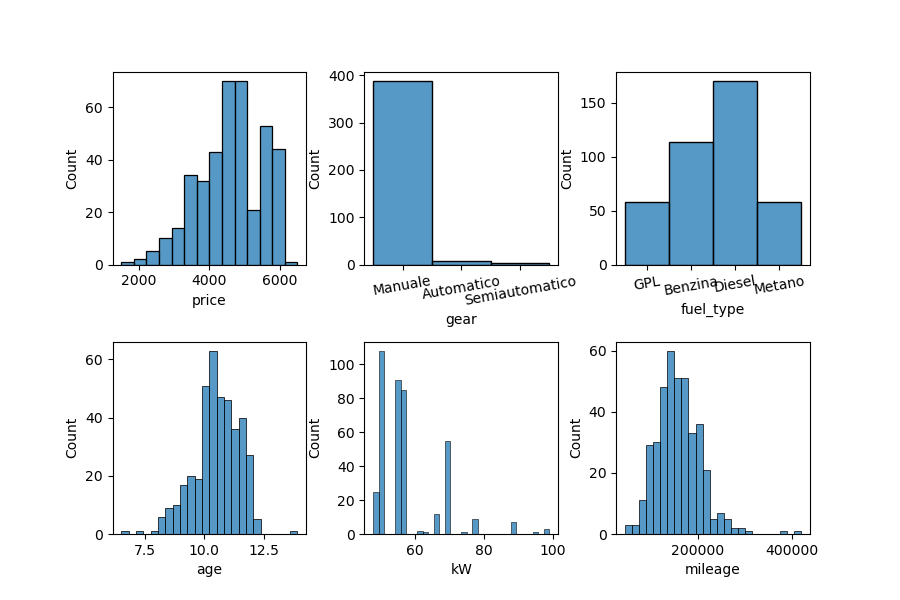

In [62]:
f, axis = plt.subplots(figsize=(9, 6), nrows=2, ncols=3, sharey=False, gridspec_kw={'hspace':0.4, 'wspace':0.3})
ax = axis.flatten()
for i,var in enumerate(['price', 'gear', 'fuel_type', 'age', 'kW','mileage']):
    g = sns.histplot(x=var, data=df, ax=ax[i])
    if i in [1,2]:
        ax[i].tick_params(axis='x', rotation=10)
f.savefig('figures/histo.pdf')

### Variables discussion

The interesting variables we believe can affect the price are: mileage, power, kW, and age. However, the power and the gear type may affect it as well. Let's check them

<IPython.core.display.Javascript object>


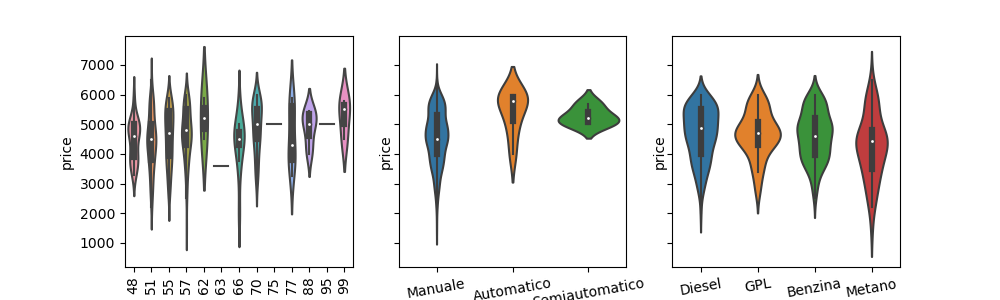

In [63]:
f, ax = plt.subplots(figsize=(10, 3), nrows=1, ncols=3, sharey=True)
g = sns.violinplot(x='kW', y='price', data=df, ax=ax[0])
ax[0].tick_params(axis='x', rotation=90)
g = sns.violinplot(x='gear', y='price', data=df,ax=ax[1], rot=90)
ax[1].tick_params(axis='x', rotation=10)
g = sns.violinplot(x='fuel_type', y='price', data=df,ax=ax[2], rot=90, order=['Diesel','GPL','Benzina','Metano'])
ax[2].tick_params(axis='x', rotation=10)

There is a light correlation for kW, and a little more for gear type. Fuel type seems to affect the price at smaller degree. Let's see their median prices ordered by descending order:

In [64]:
df[['price','fuel_type']].groupby('fuel_type').agg('median').sort_values(by='price', ascending=False)

,price
fuel_type,
Diesel,4875
GPL,4700
Benzina,4600
Metano,4445


Let's use them by transforming them into values

In [65]:
encode_gear_dict = {'Manuale':1, 'Semiautomatico':2, 'Automatico':3}
encode_fuel_dict = {'Metano':1, 'Benzina':2, 'GPL':3,'Diesel':4}

df['gear_encoded'] = df['gear'].apply(lambda x: encode_gear_dict[x])
df['fuel_encoded'] = df['fuel_type'].apply(lambda x: encode_fuel_dict[x])

### Correlations check

<IPython.core.display.Javascript object>


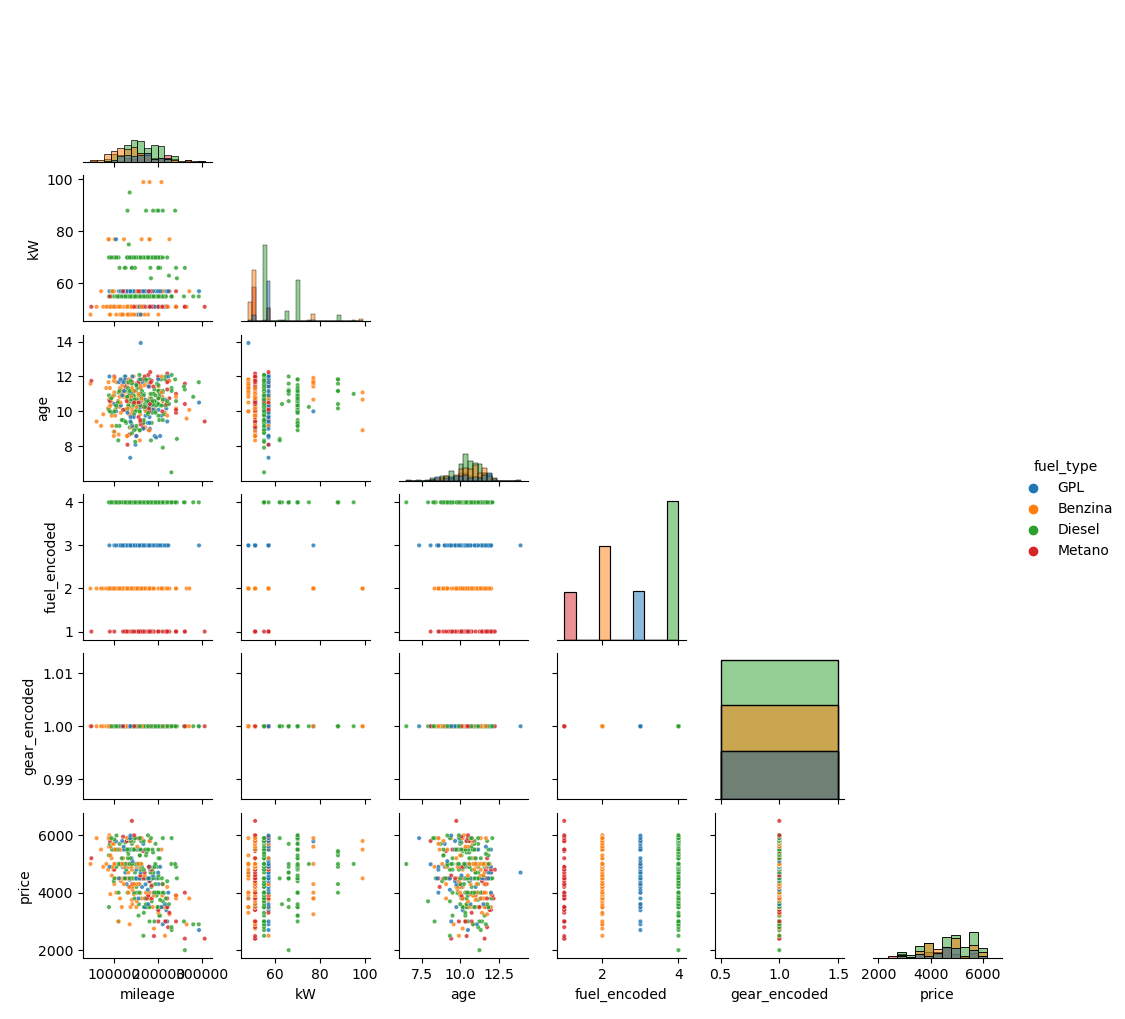

In [110]:
feat = ['mileage','kW','age','fuel_encoded','gear_encoded','price', 'fuel_type']
g = sns.pairplot(df[feat], hue="fuel_type", height=1.7, diag_kind="hist", corner=True, plot_kws={"s": 10, 'alpha':0.8})
fig = g.fig
fig.savefig('figures/pairplot.pdf')

<IPython.core.display.Javascript object>


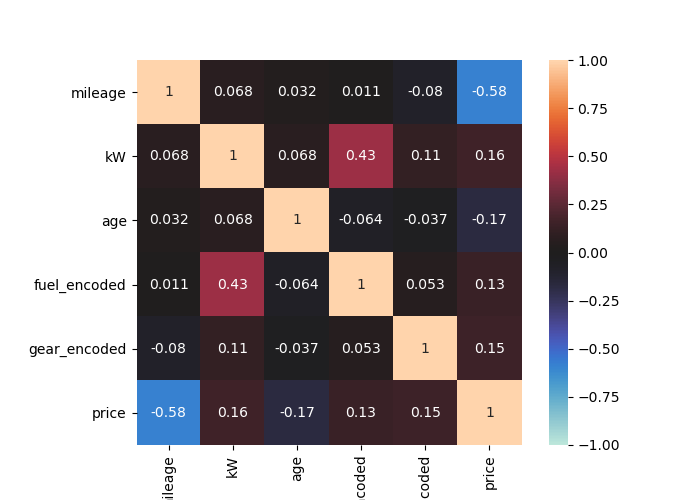

In [67]:
f, ax = plt.subplots(figsize=(7, 5))
df_corr = df[['mileage','kW','age','fuel_encoded','gear_encoded','price']].corr()
ax = sns.heatmap(df_corr, annot=True, vmin=-1, vmax=1, center=0, square=True)

## Discussion on correlation values

We have just seen the correlation between the variables. We discuss them here shortly:
+ the correlation mileage-price is clearly the most important one, pointed out by the correlation matrix but also visible by eye in the previous plots
+ kW and age vs. price have weak positive and negative correlations, respectively
+ gear type shows a weak correlation vs. price
+ fuel type shows also a positive correlation vs. price

Given that the car of our customer has manual gear and GPL fuel type, this bring us to the following considerations.
+ most of the cars have manual gear, and very few have a Semi- or Automatic gear. Besides, the latter have in average higher price. Thus, it is a good idea to drop Semi- and Automatic gear cars.
+ Similarly, we may be tempted to drop all the cars that are not GPL fuel type. In doing so, we would leave few cars as sample (58 cars). Besides, the average difference in car's price for the different fuel type is small. Thus, we decided to keep in the sample cars with any fuel type.

There are also two outliers cars with very high mileage. We drop them.


In [68]:
#drop the cars with fuel type equal to "Semiautomatico" and "Automatico"
index_to_drop = df.index[df['gear'] != 'Manuale']
df.drop(index=index_to_drop, inplace=True)
#we also drop two outliers for mileage>350000
index_to_drop = df.index[df['mileage'] > 350000]
df.drop(index=index_to_drop, inplace=True)

## Set the ML model

We set here the ML model in order to esteem the market price of the customer's car.

In [69]:
#upload the necessary python packages
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb

#from sklearn.pipeline import Pipeline
#from sklearn.linear_model import Ridge
#from sklearn.preprocessing import PolynomialFeatures
#from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

from sklearn.metrics import r2_score, mean_absolute_error
#we consider only the following features
features = ['mileage','age','kW','fuel_encoded']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df['price'], test_size=0.2, random_state = 42)
#kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=2)

After some tests, during which we used ML models such as Random Forest, and KNeighbors Regressor, we choose to use the XGBoost model, which performs best.

In [71]:
params = {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'colsample_bytree': 0.8, 'learning_rate': 0.1}#, 'tree_method':'hist'
dtrain = xgb.DMatrix(data=X_train,label=y_train)
dtest = xgb.DMatrix(data=X_test,label=y_test)
#fit the model
model = xgb.train(params, dtrain, 100, early_stopping_rounds = 20, evals=[(dtest, 'dtest')], verbose_eval=10)

[0]	dtest-mae:3977.15015
Will train until dtest-mae hasn't improved in 20 rounds.
[10]	dtest-mae:1312.28174
[20]	dtest-mae:663.35138
[30]	dtest-mae:625.66089
[40]	dtest-mae:620.02014
[50]	dtest-mae:617.22961
[60]	dtest-mae:620.09149
Stopping. Best iteration:
[48]	dtest-mae:616.45319



In [106]:
y_pred =  model.predict(dtest)
mae = mean_absolute_error(y_pred, y_test)
print('mean abs error on the test set: {}'.format(mae))

mean abs error on the test set: 618.8675474509215


We want now to check by eye that the predicted value make sense. Let's see the distribution on the predicted differences "predicted minus true" on the X_test

<IPython.core.display.Javascript object>


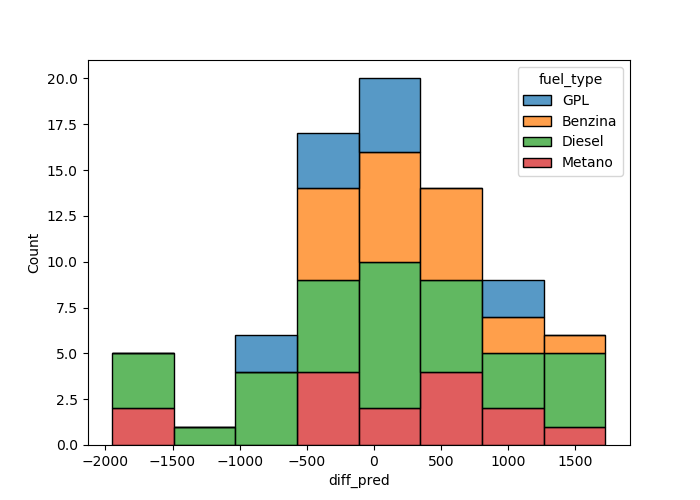

In [73]:
df['diff_pred'] = y_pred - y_test

f, ax = plt.subplots(figsize=(7, 5))
ax = sns.histplot(x='diff_pred', hue='fuel_type', multiple='stack', data=df)

The differences look fairly distributed around zero. Let's check now the mileage vs. price of the whole data set in comparison with the predicted price

<IPython.core.display.Javascript object>


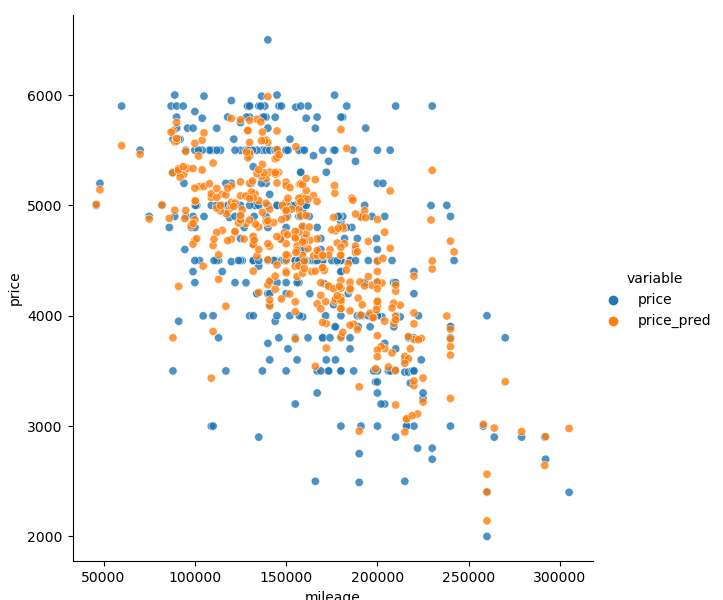

In [74]:
ddf = xgb.DMatrix(data=df[features],label=df.price)
df['price_pred'] = model.predict(ddf)
df_melt = pd.melt(df,id_vars=['mileage'], value_vars=['price','price_pred'])
df_melt.rename(columns={'value':'price'}, inplace=True)

sns.relplot(x="mileage", y="price", hue="variable", sizes=(40, 400), alpha=.8, height=6, data=df_melt)

The predicted distribution looks fair.

## Prediction

We predict noW the price of the customer's car

In [103]:
customer_car = df.loc[[1]].copy()
customer_car['mileage'] = 162000
customer_car['age'] = 11
customer_car['fuel_encoded'] = 3
customer_car['kW'] = 57

In [107]:
dcustomer = xgb.DMatrix(data=customer_car[features])
#set the predicted price
customer_car['price_pred'] = model.predict(dcustomer)[0]
customer_pred = model.predict(dcustomer)[0]
print('The predicted price is {:.0f} Euro'.format(customer_pred))
print('A reasonable interval is between {:.0f} and {:.0f} Euro'.format(customer_pred-mae, customer_pred+mae))

The predicted price is 4840 Euro
A reasonable interval is between 4221 and 5459 Euro


Because the mean absolute error given by the model on the test set is ~618 Euro, a reasonable price interval for the car should be **between 4221 and 5459 Euro**

<IPython.core.display.Javascript object>


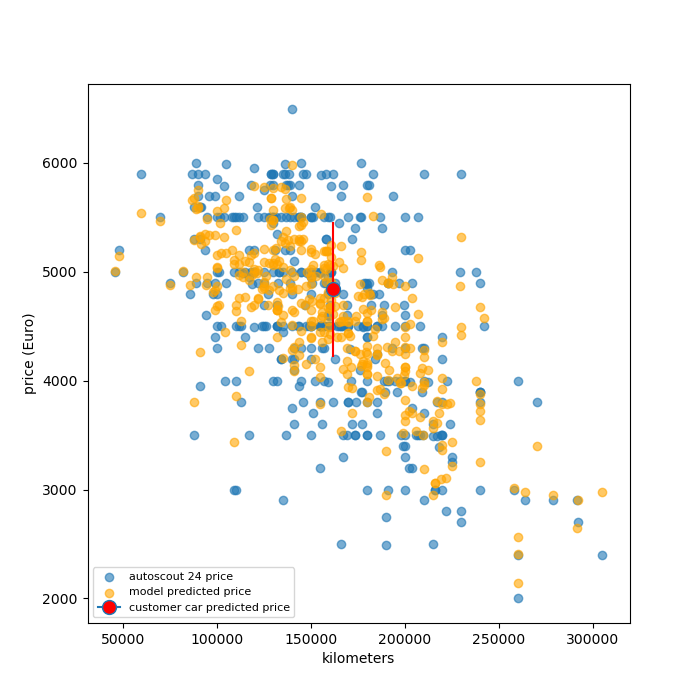

In [109]:
fig, ax = plt.subplots(figsize=(7,7))
price = plt.scatter(df.mileage, df.price, alpha=0.6)
pred = plt.scatter(df.mileage, df.price_pred, alpha=0.6, c='orange')
custom = plt.errorbar(customer_car.mileage, customer_car.price_pred, yerr=mae, mfc='red', ecolor='red', marker='o', ms=10)

# produce a legend with the unique colors from the scatter
plt.legend((price, pred, custom),
           ('autoscout 24 price', 'model predicted price', 'customer car predicted price'),
           scatterpoints=1,
           loc='lower left',
           ncol=1,
           fontsize=8)
ax.set_ylabel('price (Euro)')
ax.set_xlabel('kilometers')
fig.savefig('figures/model_prediction.pdf')